# this notebook is just for testing

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [401]:
import os
import subprocess
import json
import numpy as np
import matplotlib.pyplot as pl
import tkinter as tk #to import file
from tkinter import filedialog #to open import dialog

def print_info(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)
    print(jout)
            
def get_bitrate(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)  # Convert data from JSON string to dictionary
    return int(jout["format"]["bit_rate"])

def get_vmaf(dist,ref,r):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]scale={r[0]}x{r[1]}:flags=bicubic,setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    return i_data["pooled_metrics"]["vmaf"]["mean"]
    
def scale():
    c_seq = "ffmpeg -i test_vids/srcRAW_FullHD/rush_field_cuts_1080p.y4m \
        -filter:v scale=480x270 test_vids/srcRAW_SD/rush_field_cuts_SDp.y4m"
    subprocess.call(c_seq, shell=True)
    
def open_file():
    root = tk.Tk()
    root.withdraw()
    f = os.path.relpath(filedialog.askopenfilename())
    #file_name = os.path.basename(source_path).split('.')[0]
    return f

res = [480,270]
file = "tests_vids/OPT_vids/rush_fiel_vmaf90fx_AVC.mp4"
#file="tests_vids/OPT_vids/rush_fiel_rate1000000fx_AVC.mp4"
f_ref = "tests_vids/srcRAW_SD/rush_field_cuts_SDp.y4m"
print(get_bitrate(file))
print(get_vmaf(file,f_ref,res))
plot = {"PLOT": False, "FX": False, "BF": False, "LG": False, "CF": False, "TARGET": "rate"}

if plot["PLOT"]:
    my_dpi = 96
    pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)

    if plot["FX"]:
        folder = "tests_vids/OPT_vids/fx_"+plot["TARGET"]
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-b', label="Fixed CRF")

    if plot["BF"]:
        folder = "tests_vids/OPT_vids/bf_"+plot["TARGET"]
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-g', label="OPT bf")

    if plot["LG"]:
        folder = "tests_vids/OPT_vids/lg_"+plot["TARGET"]
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-c', label="OPT lg")

    if plot["CF"]:
        folder = "tests_vids/OPT_vids/cf_"+plot["TARGET"]
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-r', label="OPT cf")

    pl.grid(True)
    pl.title("RQ curves")
    pl.ylabel("VMAF quality")
    pl.xlabel("Bitrate (MB)")
    pl.legend(loc="lower right")
    pl.figure()


1154943
-assessed= tests_vids/OPT_vids/rush_fiel_vmaf90fx_AVC.mp4
91.227454


In [399]:
#!ffplay -f rawvideo -video_size 640x360 test_vids/downsampled/smithy_640.yuv
import numpy as np
import os
import subprocess
import json
rng = [10,40]
num_shots = 4
t_pts = {"crf": "tests_vids/srcRAW_SD/rush_field_cuts_SDp.y4m", \
            "rate": "", \
            "dist": ""}
command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {t_pts["crf"]}"
cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
jout = json.loads(cout)
print(jout)

SyntaxError: invalid syntax (3473743637.py, line 11)

[23.308242104968663]


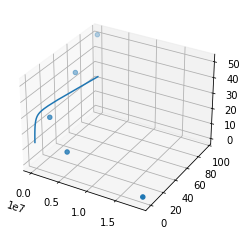

In [307]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as pl
from mpl_toolkits import mplot3d

def eq_fit(x, a, b, c):
    return a / (x + b) + c
def func(data, a, b):
    return data[:,0]*data[:,1]*a + b

A = np.array([(19,20,24), (10,40,28), (10,50,31)])
crf = np.array([0, 13, 26, 38, 51])
rates = np.array([18729544, 5554671, 1085638, 138604, 12974])
dists = np.array([8.0860000e-03, 1.0444440e+00, 1.2928326e+01, 5.9431145e+01, 9.5521998e+01])
par, cov = curve_fit(eq_fit, rates, dists)
xnew = np.linspace(rates[0],rates[-1],52)
ynew = eq_fit(xnew, *par)
params, pcov = curve_fit(func, np.array(np.vstack((rates, dists)).T), crf)
znew = func(np.array(np.vstack((xnew, ynew)).T),*params)
print(func(np.array([[rates[4],dists[4],None]]),*params))
ax = pl.figure()
ax = pl.axes(projection='3d')
ax.scatter(rates,dists,crf)
pl.plot(xnew/1000,ynew,znew)

t-slope: 0.0000051031739256
[1.10202891e-01 4.57571666e-02 2.44888823e-02 1.50055977e-02
 1.00015915e-02 7.05542424e-03 5.18395369e-03 3.93406711e-03
 3.06187997e-03 2.43186597e-03 1.96391725e-03 1.60827254e-03
 1.33273371e-03 9.65582191e-04 6.09888725e-04 4.19852275e-04
 2.89326152e-04 2.08070307e-04 1.52017717e-04 1.12337961e-04
 8.43466448e-05 6.40437398e-05 4.90657465e-05 3.78908999e-05
 2.94827808e-05 2.30038439e-05 1.57387669e-05 1.17163995e-05
 9.05988942e-06 6.88046742e-06 5.32533166e-06 4.08867196e-06
 3.15077904e-06 2.43736990e-06 1.88869285e-06 1.46586074e-06
 1.14037915e-06 8.86006652e-07 6.01207089e-07 4.98750792e-07
 4.18873369e-07 3.49238384e-07 2.92084767e-07 2.44865308e-07
 2.04867868e-07 1.71297786e-07 1.43364743e-07 1.20048654e-07
 1.00576547e-07 8.42011800e-08 7.04924270e-08 5.28793815e-08]
C-slope: 0.0000090598894161


<Figure size 432x288 with 0 Axes>

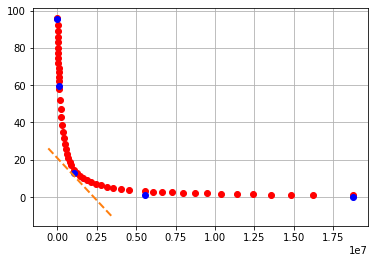

<Figure size 432x288 with 0 Axes>

In [334]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as pl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def interval(l,n):
    """
    Split an interval (l[0],l[1]) into n values

    Input:
    - l : list(2)
        Boundaries of the interval to split
    - l : int
        Number of sub-intervals to define
    Output:
    - out : np.array(n+1)
        Array of CRFs values
    """
    w = (l[1] - l[0]) / (n - 1)
    return np.array([round(l[0]+i*w) for i in range(n)])
def density_space(xs, ps, n, order=1):
    cps = cumtrapz(ps, xs, initial=0)
    cps *= (1/cps[-1]) #normalize [0,1]
    intfunc = interp1d(cps, xs, kind=order)
    t = intfunc(np.linspace(0, 1, n, endpoint=False))
    return t

def eq_fit(x, a, b, c):
    #return a * np.log(x + b) + c
    #return a*x**2 + b*x + c
    #return c + (a / np.log2(x + b))
    return a / (x + b) + c
def compute_slope(xl,yl,xr,yr):
    return -(yl-yr)/(xl-xr)
def as_slope(x, a):
    return a / (x ** 2)
def line(x, x1, y1):
    print("C-slope: "+str("%.16f" % as_slope(x1, par[0])))
    return -as_slope(x1, par[0])*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-2000000, x1+2000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)
    
def intrp(i):
    intv = crf[i+1]-crf[i]
    t = np.linspace(x[i],x[i+1],num=intv,endpoint=False)
    tn = density_space(t,eq_fit(t,*par),n=intv)
    return tn


crf = np.array([0, 13, 26, 38, 51])
rates = np.array([18729544, 5554671, 1085638, 138604, 12974])
dists = np.array([8.0860000e-03, 1.0444440e+00, 1.2928326e+01, 5.9431145e+01, 9.5521998e+01])
par, cov = curve_fit(eq_fit, rates, dists, bounds=(0,np.inf))
x = np.flip(rates)
t_pts["rate"][shot index] = np.append(np.concatenate([np.linspace(x[i],x[i+1],num=global_.npts[i+1]-global_.npts[i],endpoint=False) for i in range(config["ENC"]["NUM_INTERVALS"]-1)]),x[-1])
#xnew = np.concatenate([np.linspace(x[i],x[i+1],num=crf[i+1]-crf[i],endpoint=False) for i in range(len(x)-1)])
xnew = np.concatenate([intrp(i) for i in range(len(x)-1)])
xnew = np.append(xnew,x[-1])
ynew = eq_fit(xnew, *par)
t_ext = compute_slope(rates[4],dists[4],rates[0],dists[0])
print("t-slope: "+str("%.16f" % t_ext))
print(as_slope(xnew, par[0]))
#print(np.argmin(abs(t_ext-(par[0]/np.einsum('i,i->i',xnew,xnew)))))
#pl.plot(fun_curve, 'go')
pl.plot(xnew, ynew, 'ro')
pl.plot(rates, dists, 'bo')
show_tangent(xnew[28],fun_curve[28])
pl.grid(True)
pl.figure()

## math-array operations

In [ ]:
import numpy as np


## plots

In [ ]:
import matplotlib.pyplot as pl

In [ ]:
my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
pl.plot(rate/1000, 100-dist, 'bo')
#pl.plot([start[0],end[0]],[start[1],end[1]])
pl.grid(True)
pl.title("RD shot 0 - points")
pl.ylabel("Distortion IVMAF")
pl.xlabel("MB Rate")
pl.figure()

[
